In [576]:
# import libraries for data manipulation, analysis and visualisation
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn import neighbors
from sklearn.model_selection import GridSearchCV 
from sklearn.preprocessing import StandardScaler
import requests
sns.set()

In [207]:
# import data from all csv files in the raw_data folder into dataframes
df = pd.DataFrame()
lst = os.listdir('raw_data')
lst.sort()
for filename in lst:
    f = os.path.join('raw_data', filename)
    if f.endswith('.csv'):
        df = pd.concat([df, pd.read_csv(f)], ignore_index=True)

In [378]:
# create a new column for the decade of each song

decades = ['1960', '1970', '1980', '1990', '2000', '2010']
decade_length = []
decade_column = []
for filename in lst:
    f = os.path.join('raw_data', filename)
    if f.endswith('.csv'):
        decade_length.append(pd.read_csv(f).shape[0])
for i in range(len(decade_length)):
    decade_column.extend([decades[i]] * decade_length[i])
df['decade'] = decade_column
print(decade_length)

[8642, 7766, 6908, 5520, 5872, 6398]


In [616]:
# log into spotify api using client credentials, and get metadata for a song using its uri
client_credentials_manager = SpotifyClientCredentials(client_id='00192ef409c4480c8ecad758c9ed8478', client_secret='f6a4d11d5187418a99b8045ec84fb3b6')
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

In [671]:
# use requests to log into spotify api using client credentials, and get release date for a song using its uri
def get_song_info(uri):
    url = 'https://api.spotify.com/v1/tracks/' + uri.split(':')[2]
    headers = {'Authorization': 'Bearer ' + client_credentials_manager.get_access_token(as_dict=False)}
    r = requests.get(url, headers=headers)
    print(r)
    r = r.json()
    return r['album']['release_date']
    # return r


In [672]:
# log into spotify api using client credentials, and get metadata for a song using its uri
client_credentials_manager = SpotifyClientCredentials(client_id='93f1e96a79c0419daaf93072dfa3e1f4', client_secret='9f6d31cff47e436cab75aa5e31e8a773')
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

In [674]:
print(get_song_info('spotify:track:1dtKN6wwlolkM8XZy2y9C1'))

<Response [200]>
1969-03-04


In [569]:
# get the release date of a song using its uri using spotify api

def get_song_date(uri):
    # Fetch the track information
    meta = sp.track(uri)
    features = sp.audio_features(uri)
    
    # Get the album's release date from the track info
    album_uri = meta['album']['uri']
    album = sp.album(album_uri)
    release_date = album['release_date']
    
    return release_date

In [222]:
# insert empty column called release_date
df.insert(3, 'release_date', None)


In [575]:
# import data.csv as pd df
df = pd.read_csv('data.csv')

In [676]:
# save dataframe as csv file
df.to_csv('songs.csv', index=False)

In [ ]:
# check the shape of the dataframe
df.shape

(41106, 19)

In [537]:
# check the data types of the columns
df.dtypes

track                object
artist               object
uri                  object
release_date         object
danceability        float64
energy              float64
key                   int64
loudness            float64
mode                  int64
speechiness         float64
acousticness        float64
instrumentalness    float64
liveness            float64
valence             float64
tempo               float64
duration_ms           int64
time_signature        int64
chorus_hit          float64
sections              int64
target                int64
decade               object
dtype: object

In [538]:
# check the number of unique values in each column
df.nunique(axis=0)

# a bit confusing that not all tracks are unique, but this is because some tracks are released in multiple albums

track               35860
artist              11904
uri                 40560
release_date          661
danceability         1048
energy               1787
key                    12
loudness            16160
mode                    2
speechiness          1346
acousticness         4194
instrumentalness     5122
liveness             1674
valence              1609
tempo               32152
duration_ms         21517
time_signature          5
chorus_hit          39950
sections               84
target                  2
decade                  6
dtype: int64

In [540]:
# check the basic statistics of the dataframe
df.describe()

danceability        energy           key      loudness          mode  \
count  41106.000000  41106.000000  41106.000000  41106.000000  41106.000000   
mean       0.539695      0.579545      5.213594    -10.221525      0.693354   
std        0.177821      0.252628      3.534977      5.311626      0.461107   
min        0.000000      0.000251      0.000000    -49.253000      0.000000   
25%        0.420000      0.396000      2.000000    -12.816000      0.000000   
50%        0.552000      0.601000      5.000000     -9.257000      1.000000   
75%        0.669000      0.787000      8.000000     -6.374250      1.000000   
max        0.988000      1.000000     11.000000      3.744000      1.000000   

        speechiness  acousticness  instrumentalness      liveness  \
count  41106.000000  41106.000000      41106.000000  41106.000000   
mean       0.072960      0.364197          0.154416      0.201535   
std        0.086112      0.338913          0.303530      0.172959   
min        0.000000      0.000000          0.000000      0.013000   
25%        0.033700      0.039400          0.000000      0.094000   
50%        0.043400      0.258000          0.000120      0.132000   
75%        0.069800      0.676000          0.061250      0.261000   
max        0.960000      0.996000          1.000000      0.999000   

            valence         tempo   duration_ms  time_signature    chorus_hit  \
count  41106.000000  41106.000000  4.110600e+04    41106.000000  41106.000000   
mean       0.542440    119.338249  2.348776e+05        3.893689     40.106041   
std        0.267329     29.098845  1.189674e+05        0.423073     19.005515   
min        0.000000      0.000000  1.516800e+04        0.000000      0.000000   
25%        0.330000     97.397000  1.729278e+05        4.000000     27.599792   
50%        0.558000    117.565000  2.179070e+05        4.000000     35.850795   
75%        0.768000    136.494000  2.667730e+05        4.000000     47.625615   
max        0.996000    241.423000  4.170227e+06        5.000000    433.182000   

           sections        target  
count  41106.000000  41106.000000  
mean      10.475673      0.500000  
std        4.871850      0.500006  
min        0.000000      0.000000  
25%        8.000000      0.000000  
50%       10.000000      0.500000  
75%       12.000000      1.000000  
max      169.000000      1.000000

In [541]:
# check the number of null values in each column
total = df.isnull().sum().sort_values(ascending=False)
percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total,percent],axis=1,keys=["total","percent"])
missing_data.head()

total   percent
release_date      39115  0.951564
track                 0  0.000000
instrumentalness      0  0.000000
target                0  0.000000
sections              0  0.000000

In [75]:
# observe the first 5 rows of the dataframe
df.head()

track           artist  \
0                                     Misty Roses  Astrud Gilberto   
1                                      Never Ever       All Saints   
2                                     Soul Sermon    Gregg Karukas   
3                       Clarinet Marmalade - Live    Alton Purnell   
4  До смерті і довше - Drum & Base and Rock Remix         Skryabin   

                                    uri release_date  danceability  energy  \
0  spotify:track:50RBM1j1Dw7WYmsGsWg9Tm   1996-08-20         0.527   0.316   
1  spotify:track:5FTz9qQ94PyUHETyAyfYZN   2019-09-13         0.738   0.541   
2  spotify:track:6m24oe3lk1UMxq9zq4iPFi   1999-01-01         0.736   0.419   
3  spotify:track:5FOXuiLI6knVtgMUjWKj6x         1990         0.565   0.594   
4  spotify:track:6CxyIPTqSPvAPXfrIZczs4   1998-07-02         0.513   0.760   

   key  loudness  mode  speechiness  ...  instrumentalness  liveness  valence  \
0    1   -15.769     1       0.0310  ...           0.00699    0.1680    0.543   
1    1    -5.485     1       0.0311  ...           0.00000    0.0492    0.309   
2    0   -10.662     1       0.0300  ...           0.49500    0.0809    0.265   
3    5   -13.086     1       0.0646  ...           0.92600    0.6750    0.763   
4    4   -10.077     1       0.0355  ...           0.00339    0.1530    0.961   

     tempo  duration_ms  time_signature  chorus_hit  sections  target  decade  
0  116.211       158840               4    53.89523         6       0    2000  
1  134.187       387573               4    32.16853        16       1    2000  
2   93.982       237267               4    42.05369         9       0    2000  
3  114.219       375933               4    80.99693        10       0    2000  
4  153.166       430653               4    25.57331        20       0    2000  

[5 rows x 21 columns]

In [542]:
# Leave out the non-numerical columns for building the predictor
predictor_df = df.drop(['track', 'artist', 'uri', 'release_date'], axis=1)


In [543]:
predictor_df.dtypes

danceability        float64
energy              float64
key                   int64
loudness            float64
mode                  int64
speechiness         float64
acousticness        float64
instrumentalness    float64
liveness            float64
valence             float64
tempo               float64
duration_ms           int64
time_signature        int64
chorus_hit          float64
sections              int64
target                int64
decade               object
dtype: object

In [256]:

def split_data(df, decade):
    """
    Split the data into training, validation and test data for a given decade.
    
    Keyword arguments:
        df -- dataframe containing all the data
        decade -- decade of interest
    Return: 
        X_train, X_val, X_test, y_train, y_val, y_test -- split x and y data for the decade
    """
    
    # Filter the data for the decade
    df = df[df['decade'] == decade]
    # Split the data into predictor and target variables
    y = df['target']
    X = df.drop(['target', 'decade'], axis=1) 

    # Train-test split the data into 80% training, 10% validation and 10% test data
    X_tmp, X_test, y_tmp, y_test = train_test_split(X, y, train_size=0.9, test_size=0.1)
    X_train, X_val, y_train, y_val = train_test_split(X_tmp, y_tmp, train_size=0.889, test_size=0.111)

    # Scale the data, to minimise the effect of features that are on scales in different orders of magnitude
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = pd.DataFrame(scaler.transform(X_train), index=X_train.index, columns=X_train.columns)
    X_val = pd.DataFrame(scaler.transform(X_val), index=X_val.index, columns=X_val.columns)
    X_test = pd.DataFrame(scaler.transform(X_test), index=X_test.index, columns=X_test.columns)
    
    return X_train, X_val, X_test, y_train, y_val, y_test

In [289]:
def test_decade(df, decade):
    """
    Scale the data for a given decade, to test the predictor on a different decade.
    
    Keyword arguments:
        df -- dataframe containing all the data
        decade -- decade of interest
    Return: 
        X, y -- scaled x and y data for the decade
    """
    
    # Filter the data for the decade
    df = df[df['decade'] == decade]

    # Split into predictor and target variables
    y = df['target']
    X = df.drop(['target', 'decade'], axis=1) 

    # Scale the data
    scaler = StandardScaler()
    scaler.fit(X)

    X = pd.DataFrame(scaler.transform(X), index=X.index, columns=X.columns)

    return X, y

In [509]:
def logreg(X_train, X_val, X_test, y_train, y_val, y_test, df, iteration, alphas):
  """
  Train a logistic regression model on the training data, and test it on the validation and test data.

  Keyword arguments:
      X_train, X_val, X_test, y_train, y_val, y_test -- split x and y data for the decade
      df -- dataframe containing all the data
      iteration -- the decade of interest
      alphas -- dataframe containing the correlation coefficients for each feature
  Return: 
      n_scores_train --
      n_scores_val -- 
      alphas -- 
      alphas_plot -- 
  """
  
  # Create a list to store the correlation coefficients for a line plot
  alphas_plot = []

  # Train a logistic regression model on the training data
  model = LogisticRegression()
  model.fit(X_train, y_train)

  # Test the model on the validation and test data
  n_scores_val = model.score(X_val, y_val)
  n_scores_train = model.score(X_train, y_train)
  n_scores_test = model.score(X_test, y_test)

  # concatenate X_train, X_test and X_val to get the whole training set
  X_total = pd.concat([X_train, X_val, X_test], ignore_index=True)
  # do the same for y_train, y_test and y_val
  y_total = pd.concat([y_train, y_val, y_test], ignore_index=True)

  # Test the accuracy of the model on all the decades
  n_scores_decades = []
  for decade in decades:
    X_next, y_next = test_decade(df, decade)
    n_scores_decades.append(model.score(X_next, y_next))

  # Print the results
  print('\n### Model Accuracies:')
  print('Mean training Accuracy:', n_scores_train)
  print('Mean validation Accuracy:', n_scores_val)
  print('Mean test Accuracy: ', n_scores_test)

  print('\n### Model Accuracies for following decades:')
  for i in range(len(decades)):
    print(decades[i], ':', n_scores_decades[i])
  
  print('\n### Logistic Regression correlation coefficient:')
  for i in range(len(X_train.columns)):
    print(X_train.columns[i], model.coef_[0][i])
    alphas.loc[len(alphas)] = [X_train.columns[i], model.coef_[0][i], iteration]      # add the correlation coefficient to the dataframe for the heatmap
    alphas_plot.append(model.coef_[0][i])                                             # add the correlation coefficient to the list for the line plot
  alphas_plot.append(iteration)                                                       # add the decade to the list for the line plot
  
  return n_scores_train, n_scores_val, alphas, alphas_plot

In [510]:
# Create a 2D dataframe to store the correlation coefficients for each feature for the heatmap
alphas = pd.DataFrame(columns=['feature', 'alpha', 'decade'])
# Create a list to store the correlation coefficients for each feature for the line plot
alphas_total = []

# Train a logistic regression model for each decade and print out the accuracy scores
for decade in decades:
    print(decade)
    X_train, X_val, X_test, y_train, y_val, y_test = split_data(predictor_df, decade)
    n_scores_train, n_scores_val, alphas, alphas_plot = logreg(X_train, X_val, X_test, y_train, y_val, y_test, predictor_df, decade, alphas)
    alphas_total.append(alphas_plot)
    print('---------------------------------------------\n')


1960

### Model Accuracies:
Mean training Accuracy: 0.7225517141617243
Mean validation Accuracy: 0.7268518518518519
Mean test Accuracy:  0.7260115606936416

### Model Accuracies for following decades:
1960 : 0.7226336496181439
1970 : 0.686840072109194
1980 : 0.7022292993630573
1990 : 0.6536231884057971
2000 : 0.6789850136239782
2010 : 0.6673960612691466

### Logistic Regression correlation coefficient:
danceability 0.24704116424363629
energy 0.20052885701568904
key 0.0823784744080194
loudness 0.1483028654426654
mode 0.3725337678632543
speechiness -0.6942835936468997
acousticness -0.3316637765034402
instrumentalness -0.6712363977061009
liveness 0.10661992690422968
valence 0.09389029657206256
tempo 0.1449446580771855
duration_ms -0.6115955533452778
time_signature -0.07694431015254215
chorus_hit 0.05079369282478334
sections 0.16119158294202518
LogisticRegression()
---------------------------------------------

1970

### Model Accuracies:
Mean training Accuracy: 0.7109286978915178
Mean val

In [514]:
# Format the dataframe for the line plot
alphas_plot = pd.DataFrame(alphas_total, columns=['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms', 'time_signature', 'chorus_hit', 'sections', 'decade'])

print(alphas_plot)

   danceability    energy       key  loudness      mode  speechiness  \
0      0.247041  0.200529  0.082378  0.148303  0.372534    -0.694284   
1      0.496609  0.020503 -0.022510  0.171875  0.148562    -0.473753   
2      0.851549 -0.139622  0.032584  0.464516  0.123837    -1.045217   
3      1.310904 -0.493164  0.108029  0.849739  0.091792    -0.167739   
4      1.081846 -1.498646  0.011399  2.236763  0.269653     0.030613   
5      0.628524 -1.396443  0.012516  1.899823  0.084179    -0.024894   

   acousticness  instrumentalness  liveness   valence     tempo  duration_ms  \
0     -0.331664         -0.671236  0.106620  0.093890  0.144945    -0.611596   
1     -0.461659         -0.868945 -0.023325 -0.071689  0.008994     0.190555   
2     -0.607704         -1.146018 -0.144030 -0.177881  0.187637     0.216258   
3     -0.954272         -1.292702 -0.193169 -0.462665  0.105449     0.500061   
4     -0.662191         -1.825010 -0.085073 -0.111993  0.066252    -0.202750   
5     -0.491259

    variable         value
0    feature  danceability
1    feature        energy
2    feature           key
3    feature      loudness
4    feature          mode
..       ...           ...
265   decade          2010
266   decade          2010
267   decade          2010
268   decade          2010
269   decade          2010

[270 rows x 2 columns]
        feature     alpha decade
0  danceability  0.247041   1960
1        energy  0.200529   1960
2           key  0.082378   1960
3      loudness  0.148303   1960
4          mode  0.372534   1960


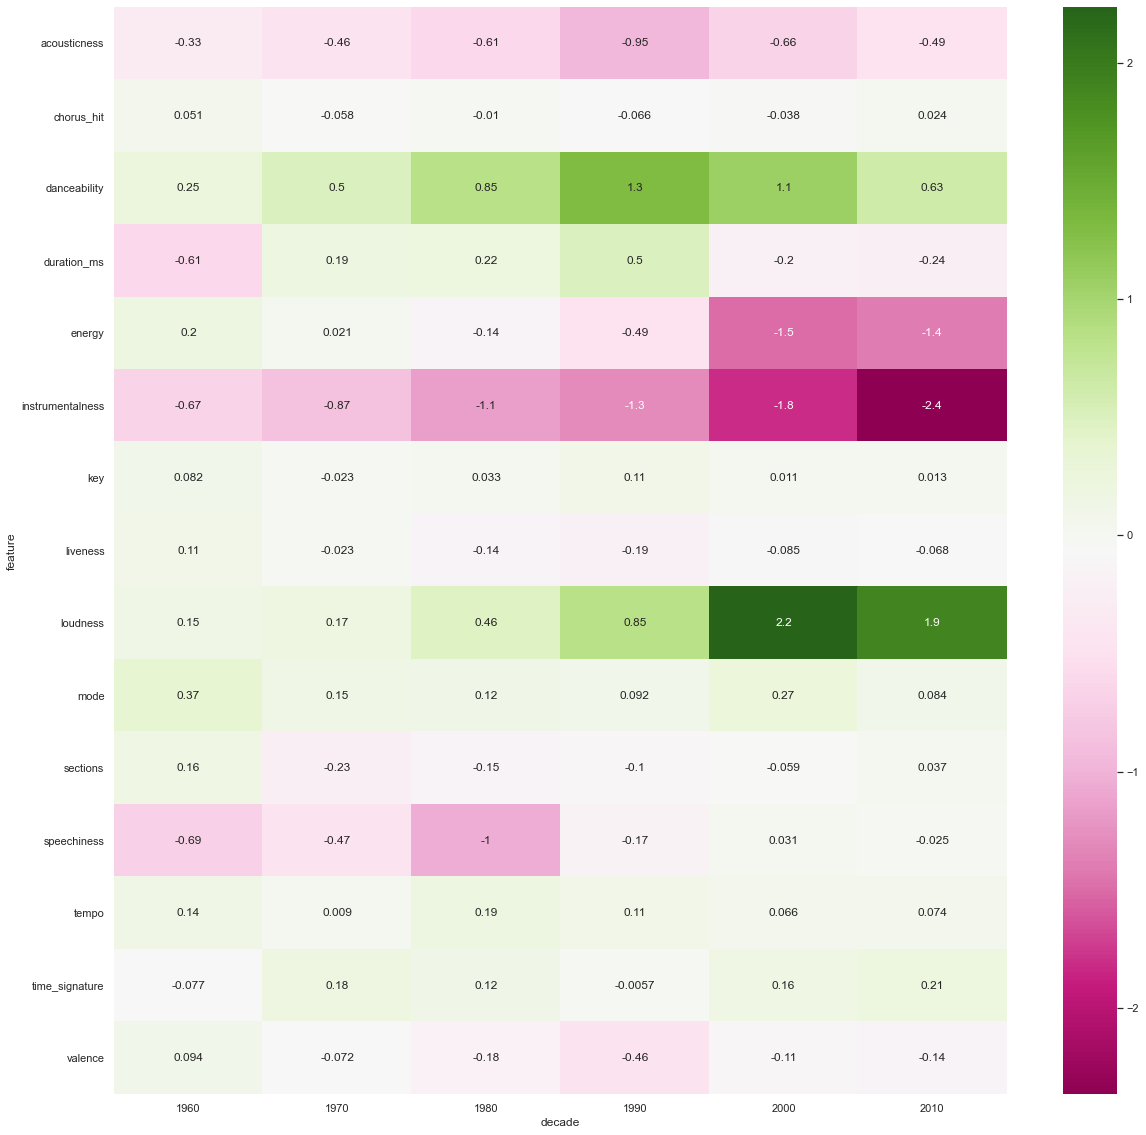

In [544]:
# Plot the correlation coefficients heatmap for all features, per decade

sns.set(rc={'figure.figsize':(20,20)})
sns.heatmap(alphas.pivot(index='feature', columns='decade', values='alpha'), cmap="PiYG", annot=True)
plt.show()

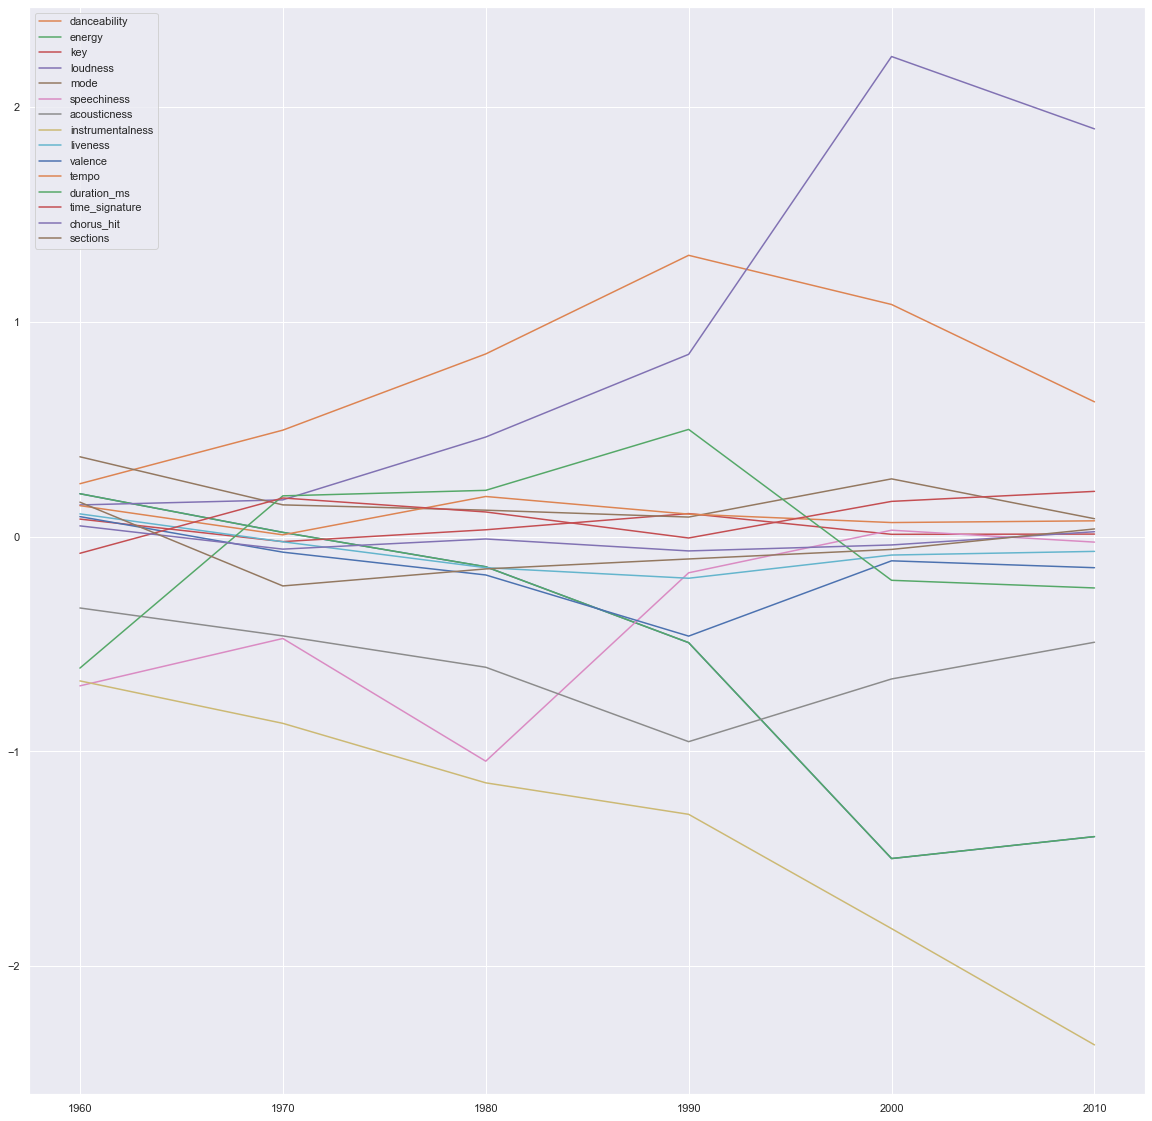

In [524]:
# Plot the correlation coefficients line plot for all features, per decade

plt.plot(alphas_plot['decade'], alphas_plot['energy'])

for col in alphas_plot.columns:
    if col != 'decade':
        plt.plot(alphas_plot['decade'], alphas_plot[col], label=col)
plt.legend()
plt.show()

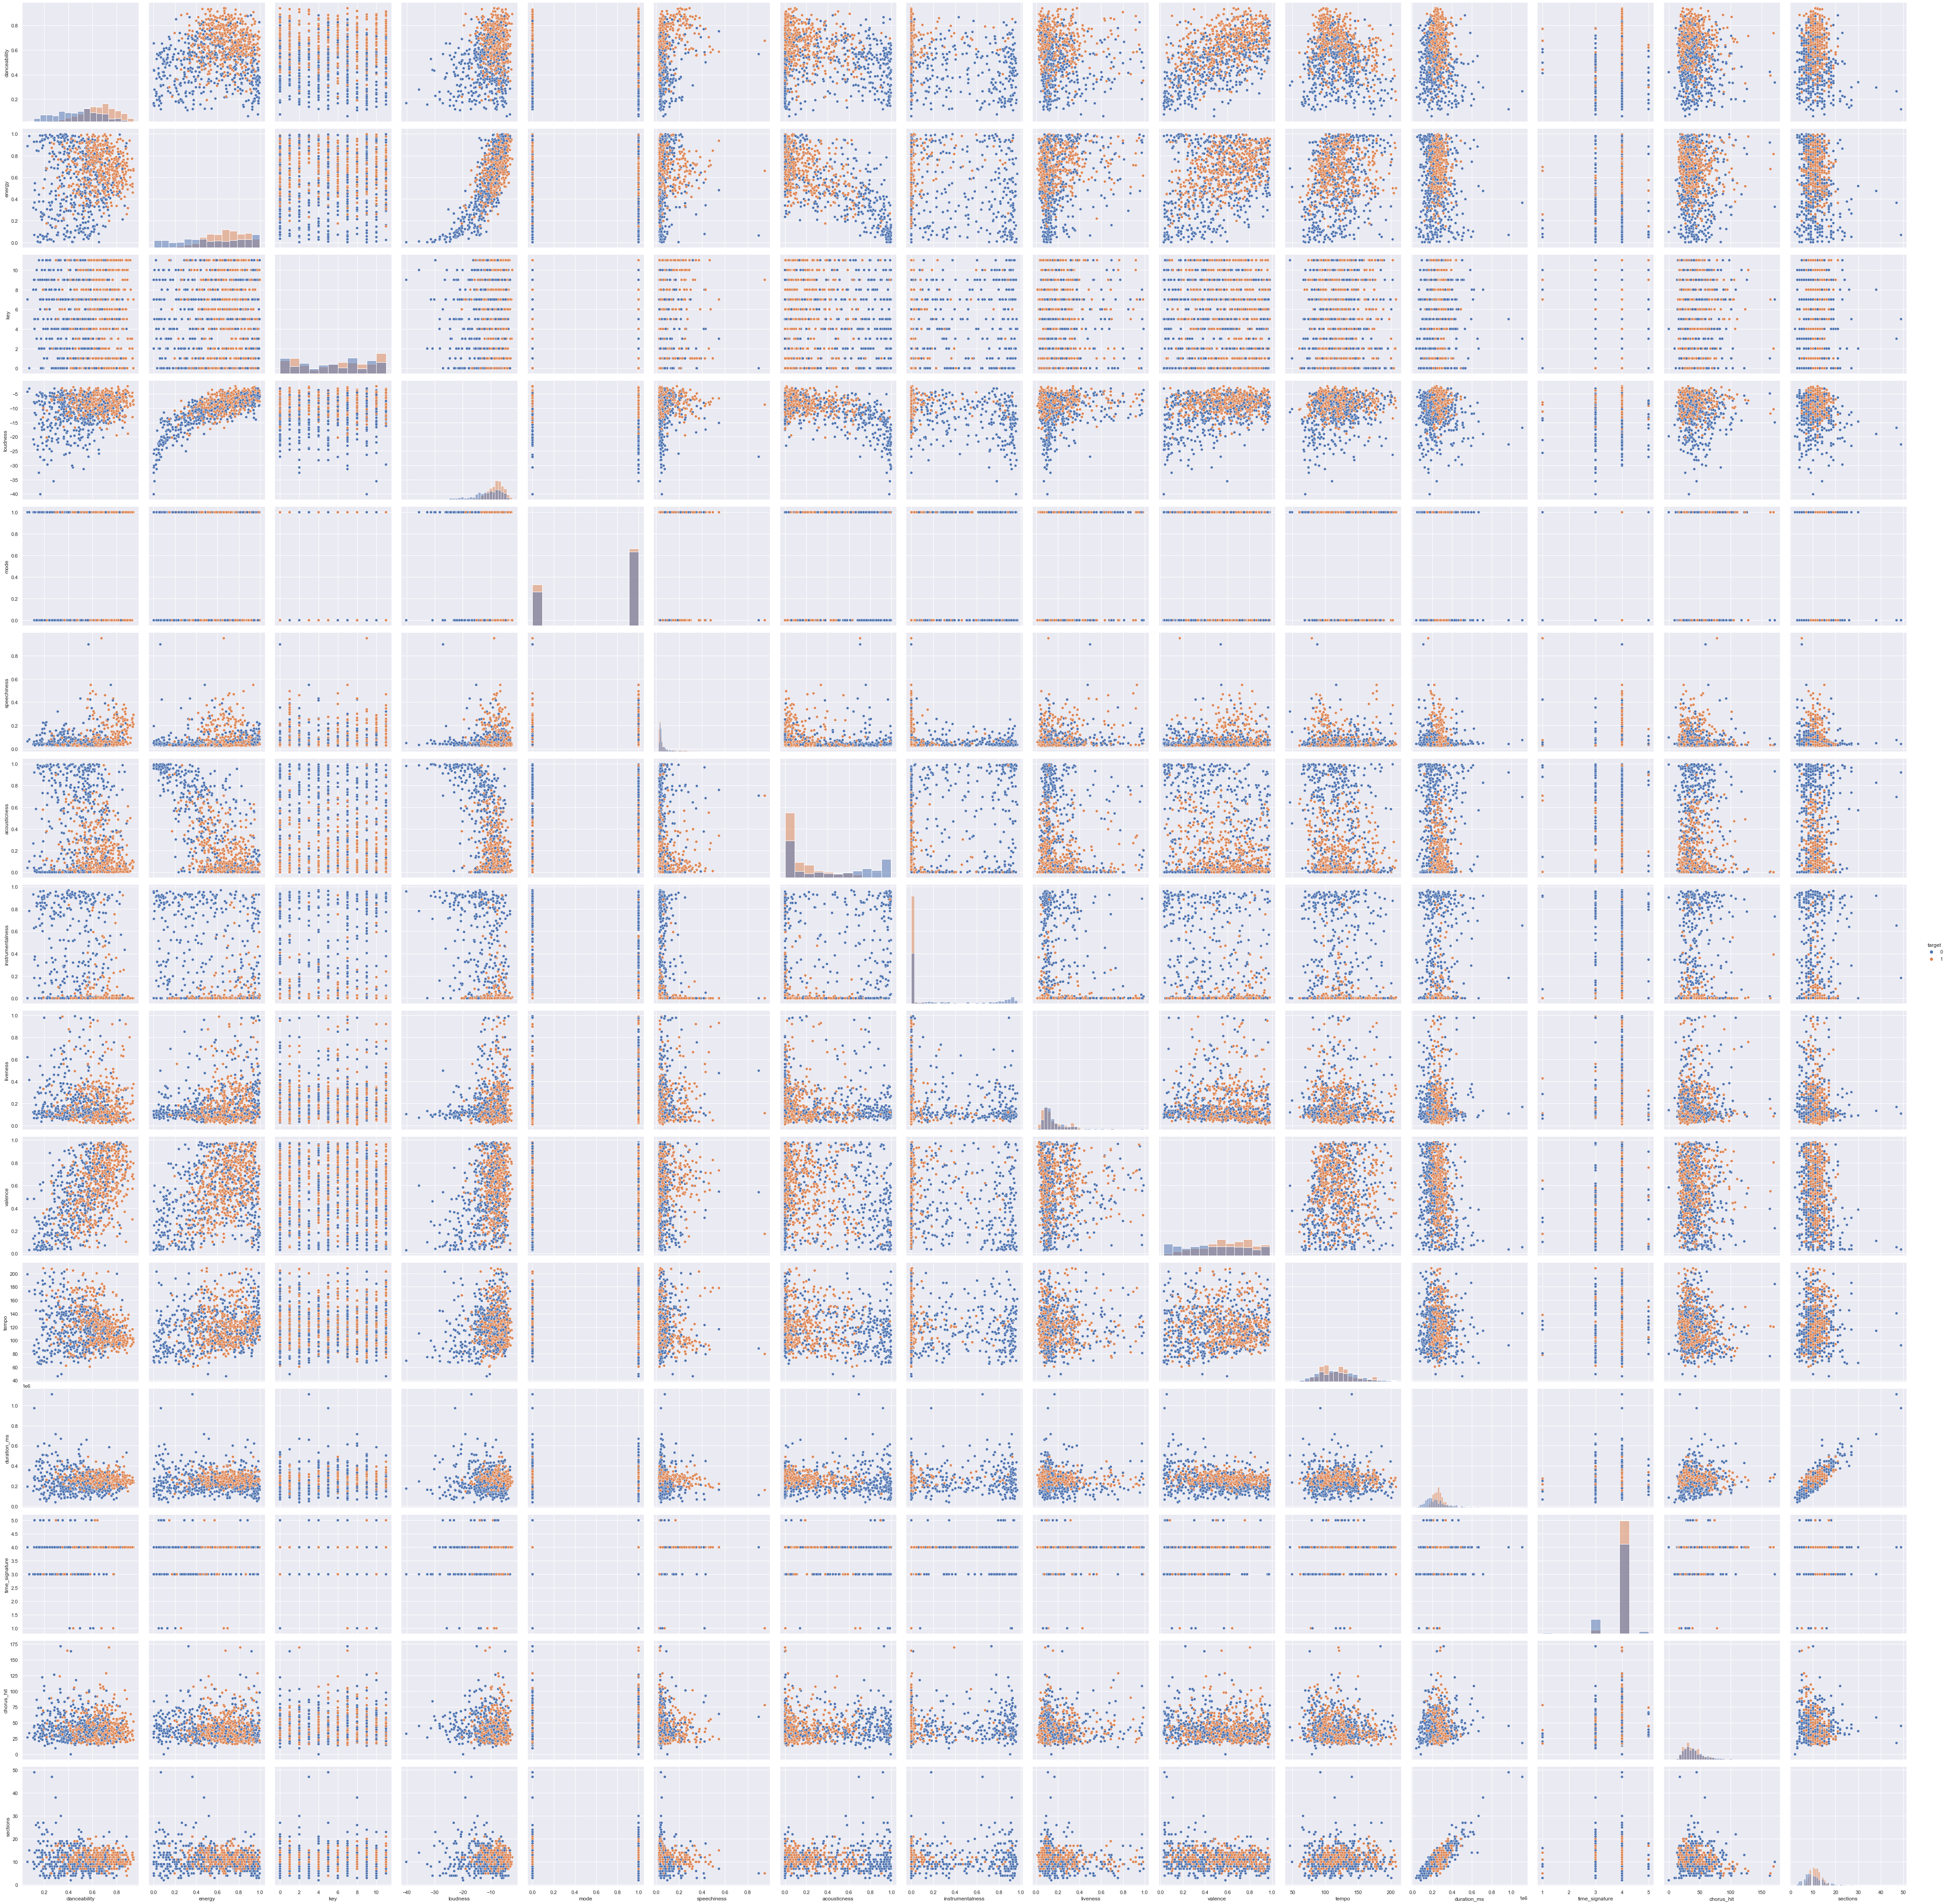

In [ ]:
g = sns.PairGrid(df2, hue='target', height=4)
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)
g.add_legend()


plt.show()